In [16]:
import numpy as np
import cv2, glob, imageio
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

# We need this to resolve deps issue
imageio.plugins.ffmpeg.download()
%matplotlib inline

In [17]:
# Conversion pixels <-> meters
ym_per_px = 30 / 720
xm_per_px = 3.5 / (1280 / 3)

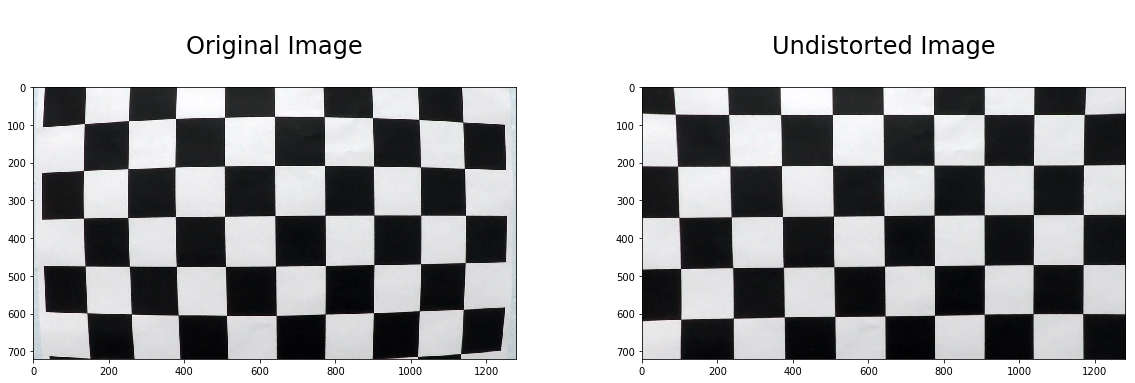

In [19]:
# Camera calibration
from utils.img import get_mtx_dist, undistort

mtx, dist = get_mtx_dist('camera_cal/calibration*.jpg')

# Display result
orig_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = undistort(orig_img, mtx, dist)

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(orig_img)
ax1.set_title('\nOriginal Image\n', fontsize=24)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(undistorted_img)
ax2.set_title('\nUndistorted Image\n', fontsize=24)

fig.savefig('output_images/calibration.png', bbox_inches='tight')

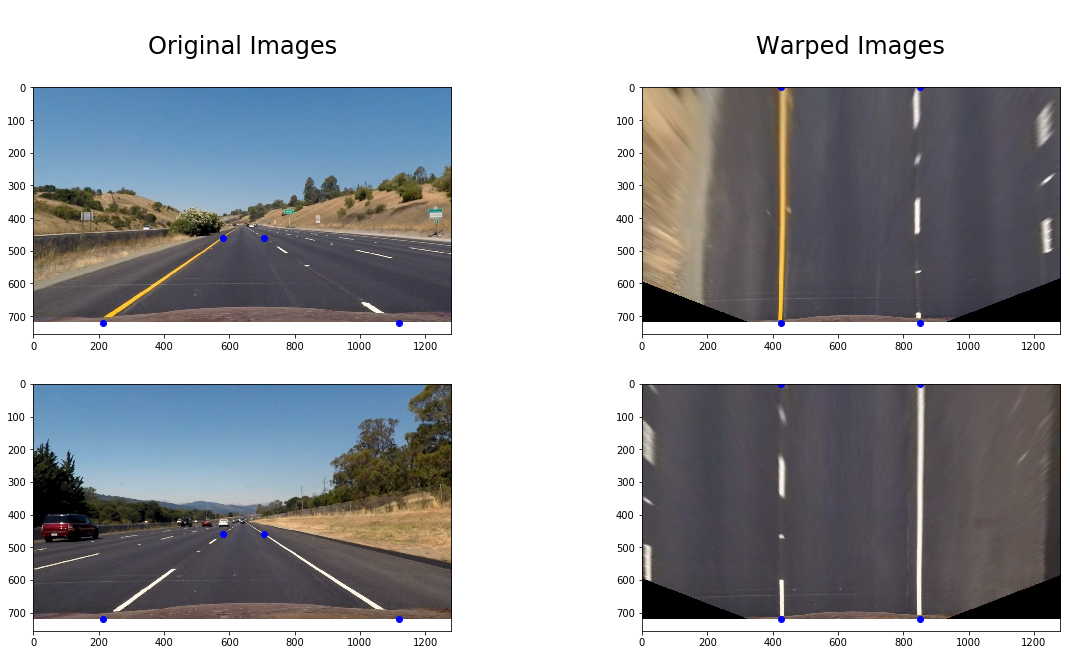

In [20]:
# Perspective transform
from utils.img import prepare, warp, get_m_minv

# Source points
SRC = [
    [ 215, 720 ], # Lower left
    [ 580, 460 ], # Upper left
    [ 705, 460 ], # Upper right
    [ 1120, 720 ] # Lower right
]

# Destination points
DST = [
    [ 426, 720 ], # Lower left
    [ 426, 0 ],   # Upper left
    [ 852, 0 ],   # Upper right
    [ 852, 720 ]  # Lower right
]

# Get transform and inverse transform matrices
M, Minv = get_m_minv(SRC, DST)
# Get images
images = np.array([ prepare(p, mtx, dist) for p in glob.glob('test_images/straight_lines*.jpg') ])
# Warp images
warped_images = np.uint8([warp(img, M) for img in images])

# Plot images (before and after)
fig = plt.figure(figsize=(20, 10))

for i in range(len(images)):
    ax1 = fig.add_subplot(2, 2, 2*i+1)
    plt.imshow(images[i,:,:,::-1])
    for p in SRC:
        plt.plot(p[0], p[1], 'bo')
    
    ax2 = fig.add_subplot(2, 2, 2*i+2)
    plt.imshow(warped_images[i,:,:,::-1])
    for p in DST:
        plt.plot(p[0], p[1], 'bo')
    
    # First line should have a title
    if not i:
        ax1.set_title('\nOriginal Images\n', fontsize=24)
        ax2.set_title('\nWarped Images\n', fontsize=24)

fig.savefig('output_images/warped.png', bbox_inches='tight')

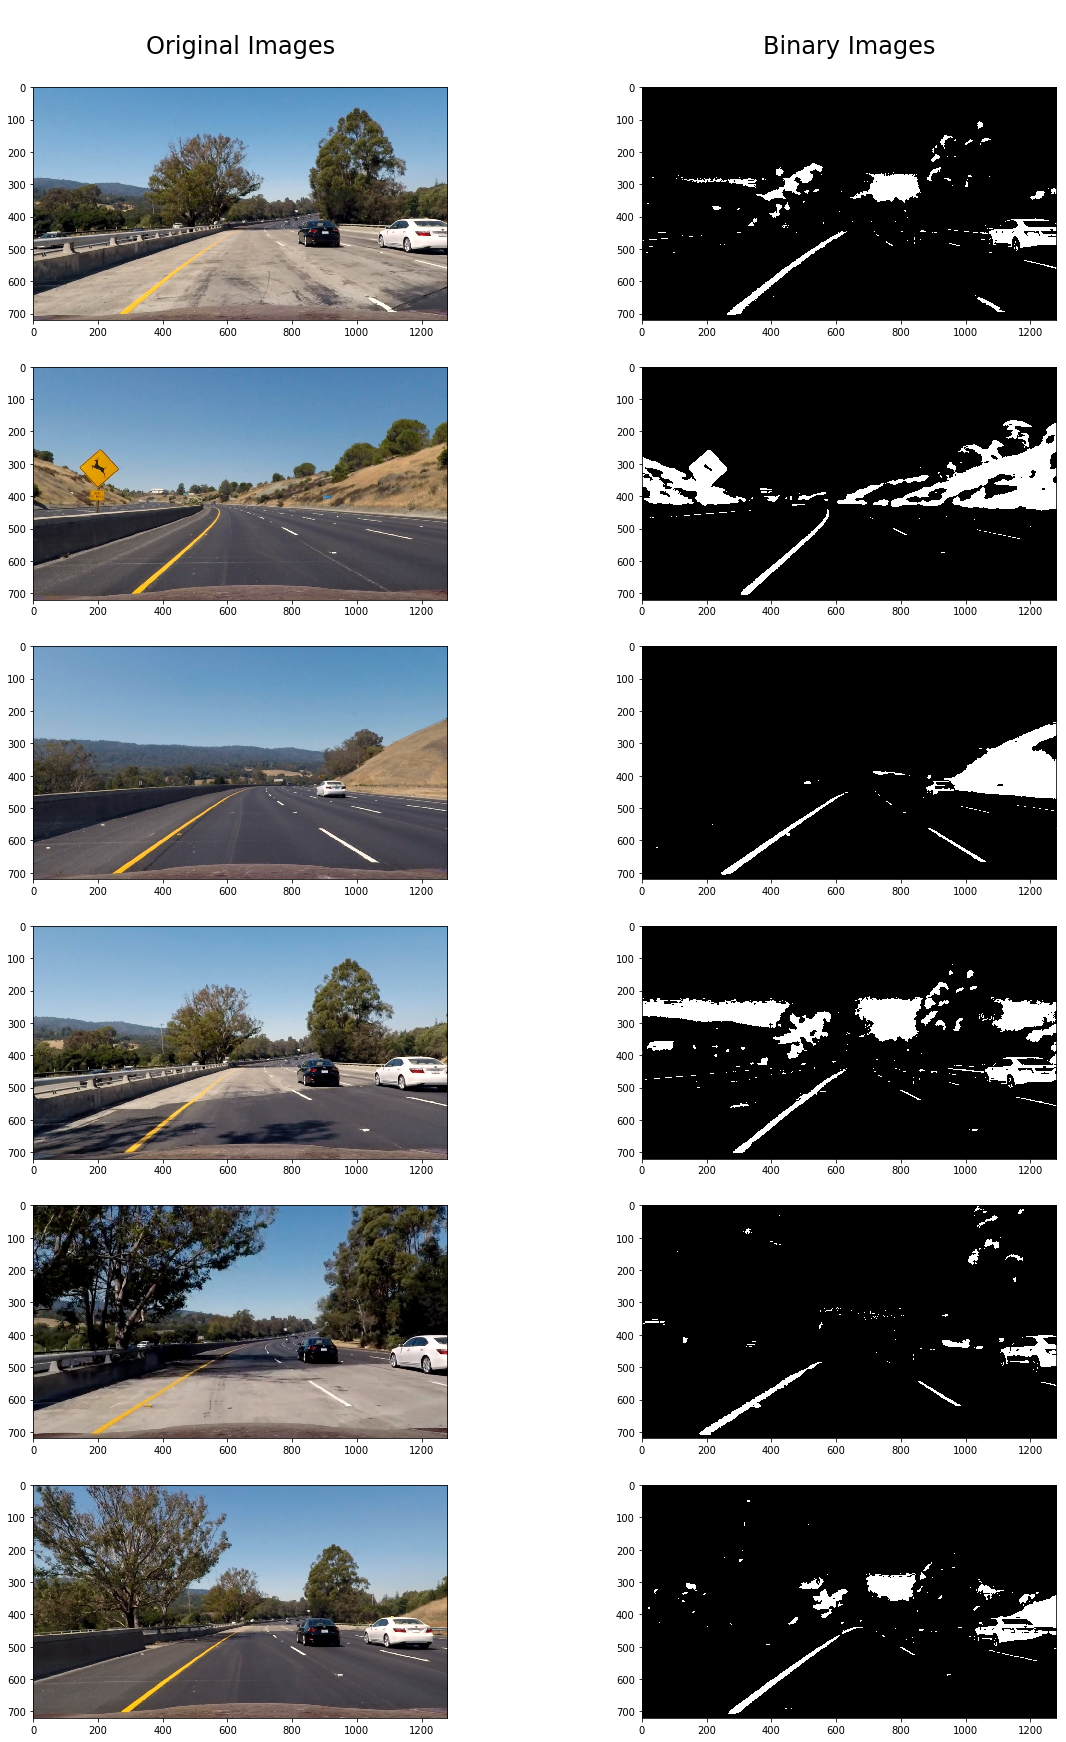

In [21]:
from utils.img import process

images = np.array([ prepare(path, mtx, dist) for path in glob.glob('test_images/test*.jpg') ])
processed_images = np.uint8([process(img) for img in images])


# Plot images (before and after)
fig = plt.figure(figsize=(20, 30))

for i in range(len(images)):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(images[i,:,:,::-1])
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(processed_images[i], cmap='gray')
    
    # First line should have a title
    if not i:
        ax1.set_title('\nOriginal Images\n', fontsize=24)
        ax2.set_title('\nBinary Images\n', fontsize=24)
        
fig.savefig('output_images/binary.png', bbox_inches='tight')

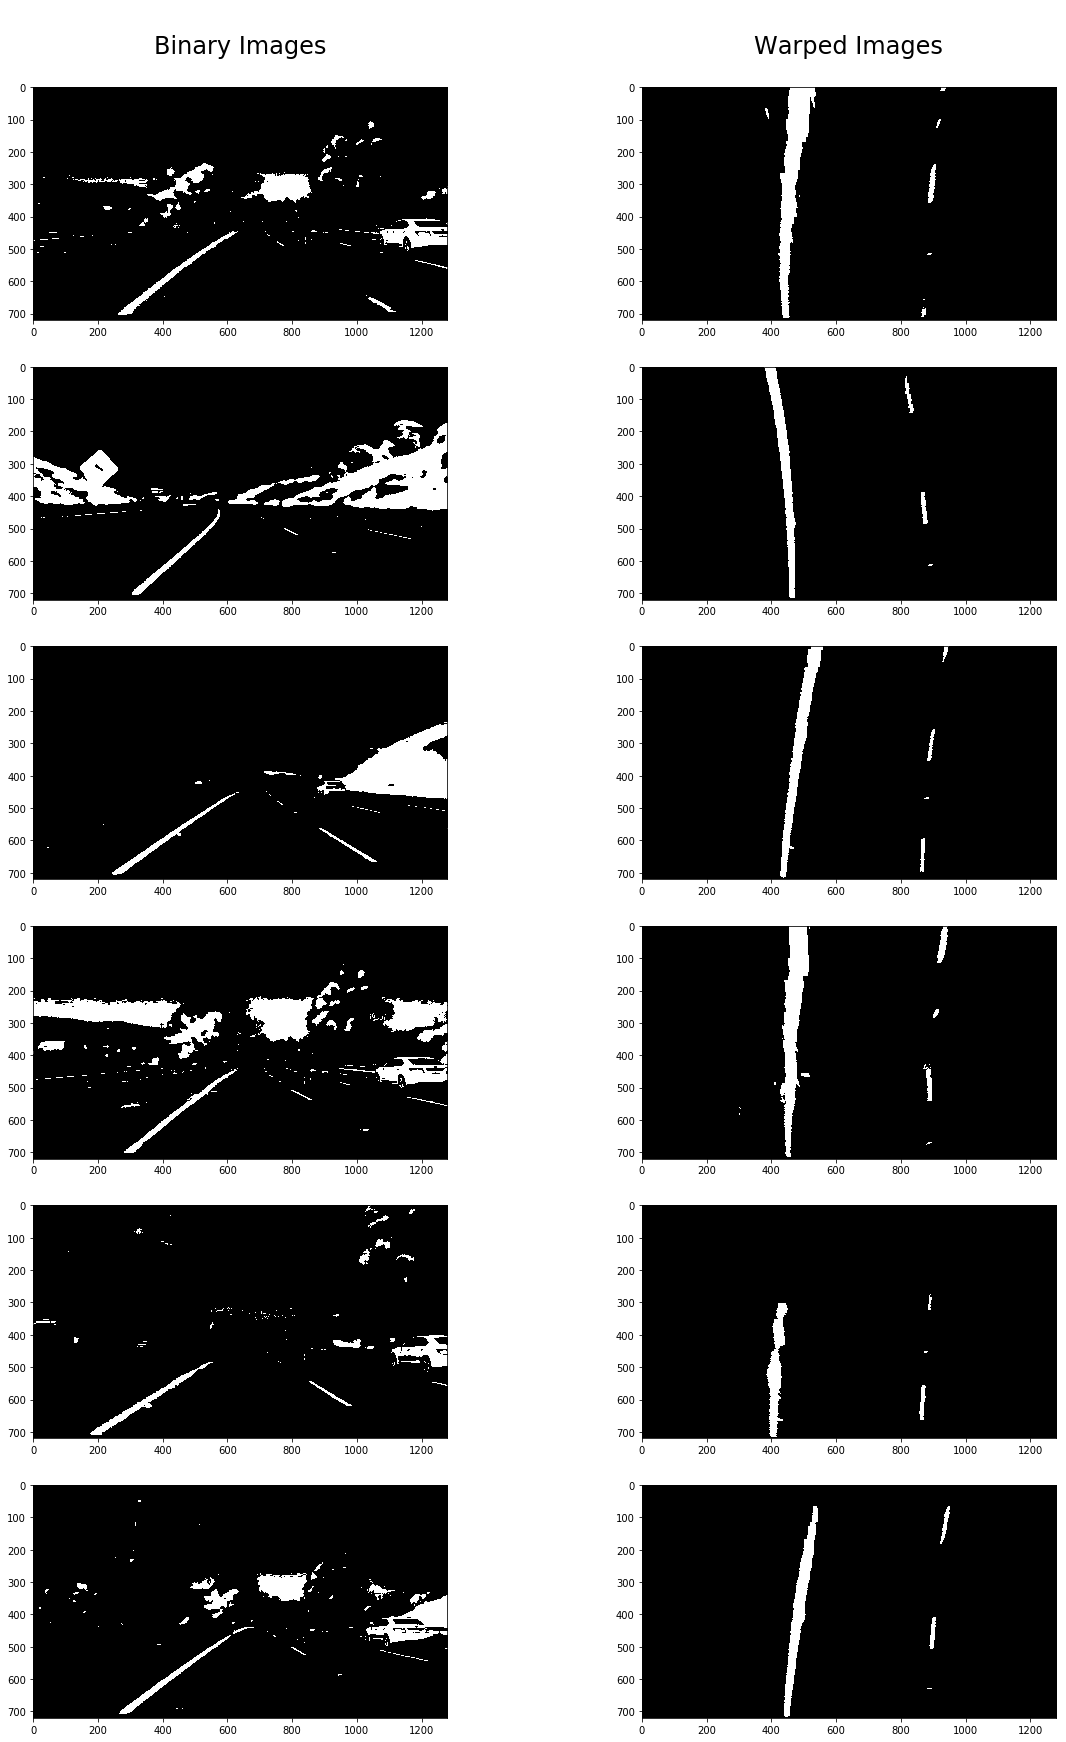

In [22]:
from utils.img import region_mask

warped_images = np.uint8([ warp(img, M) for img in processed_images ])
masked_images = np.uint8([ region_mask(img) for img in warped_images ])

# Plot images (before and after)
fig = plt.figure(figsize=(20, 30))

for i in range(len(warped_images)):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(processed_images[i], cmap='gray')
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(masked_images[i], cmap='gray')
    
    # First line should have a title
    if not i:
        ax1.set_title('\nBinary Images\n', fontsize=24)
        ax2.set_title('\nWarped Images\n', fontsize=24)
        
fig.savefig('output_images/binary_warped.png', bbox_inches='tight')

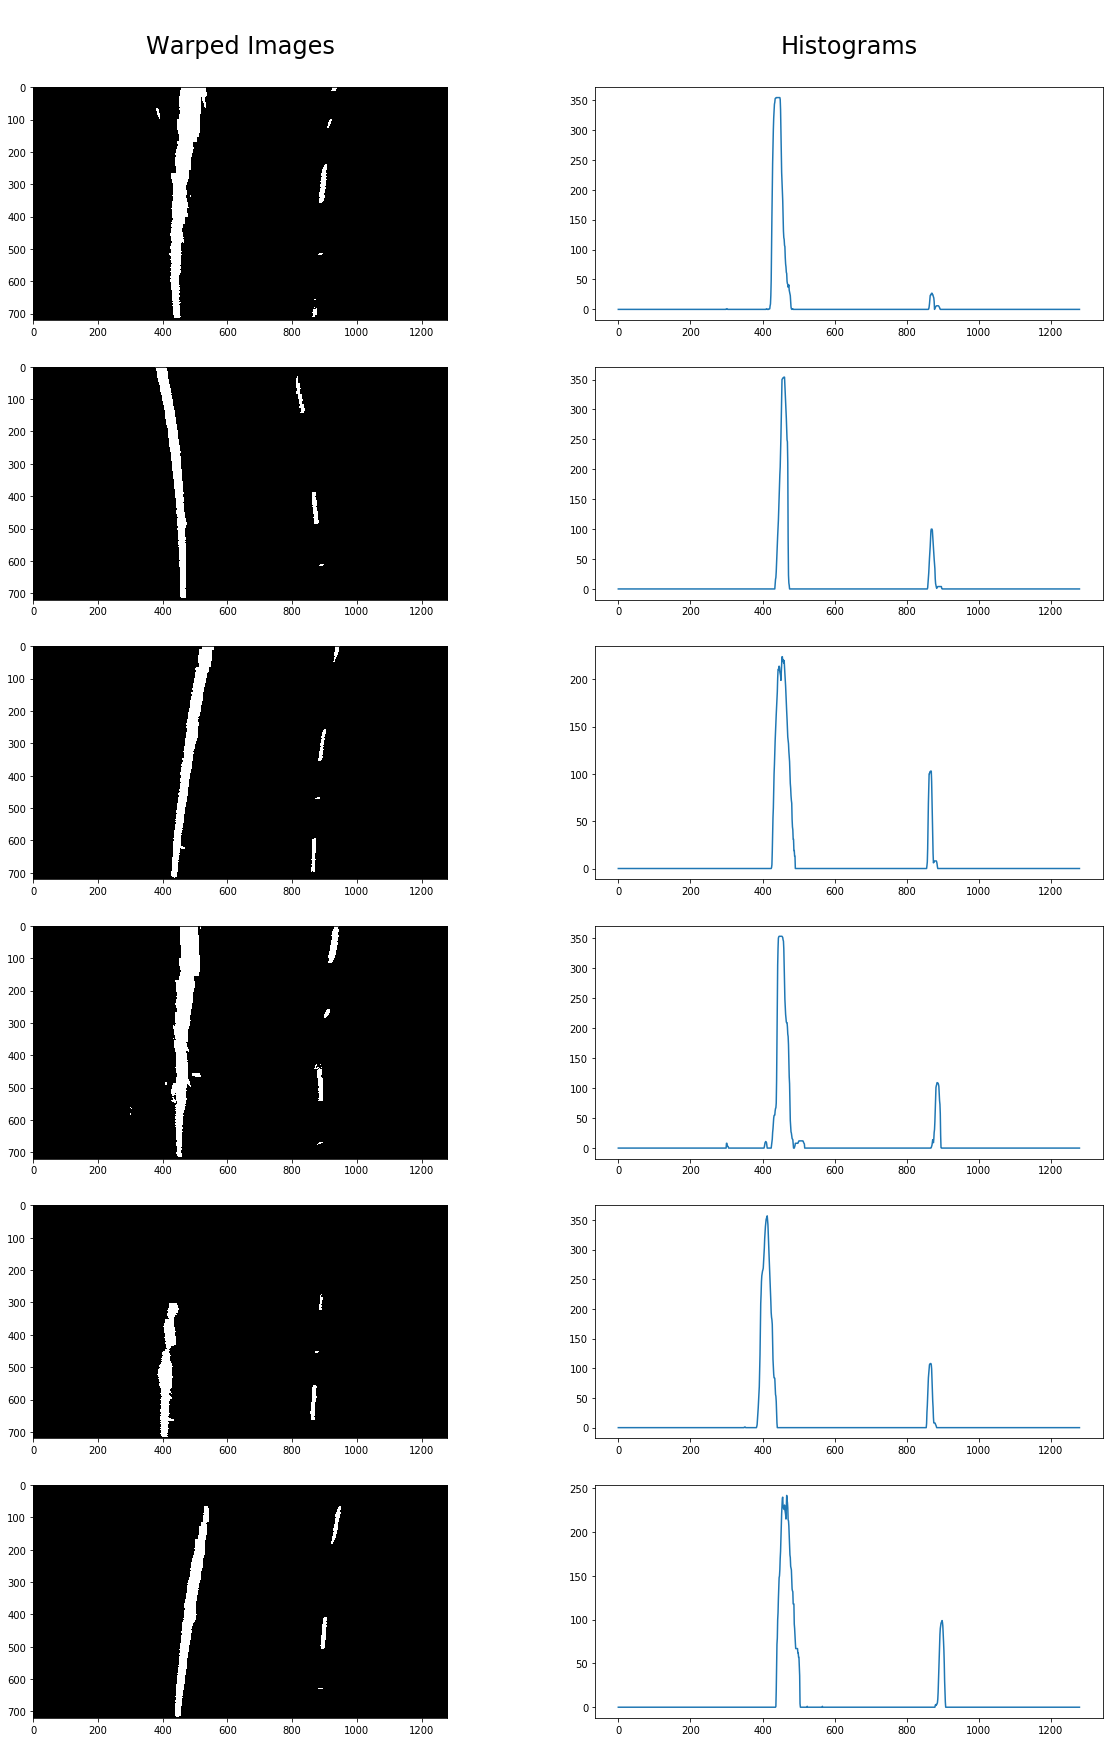

In [23]:
from utils.img import get_histogram

# Plot images and histograms
fig = plt.figure(figsize=(20, 30))

for i in range(len(masked_images)):
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(masked_images[i], cmap="gray")
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.plot(get_histogram(masked_images[i]))
    
    # First line should have a title
    if not i:
        ax1.set_title('\nWarped Images\n', fontsize=24)
        ax2.set_title('\nHistograms\n', fontsize=24)

fig.savefig('output_images/histograms.png', bbox_inches='tight')

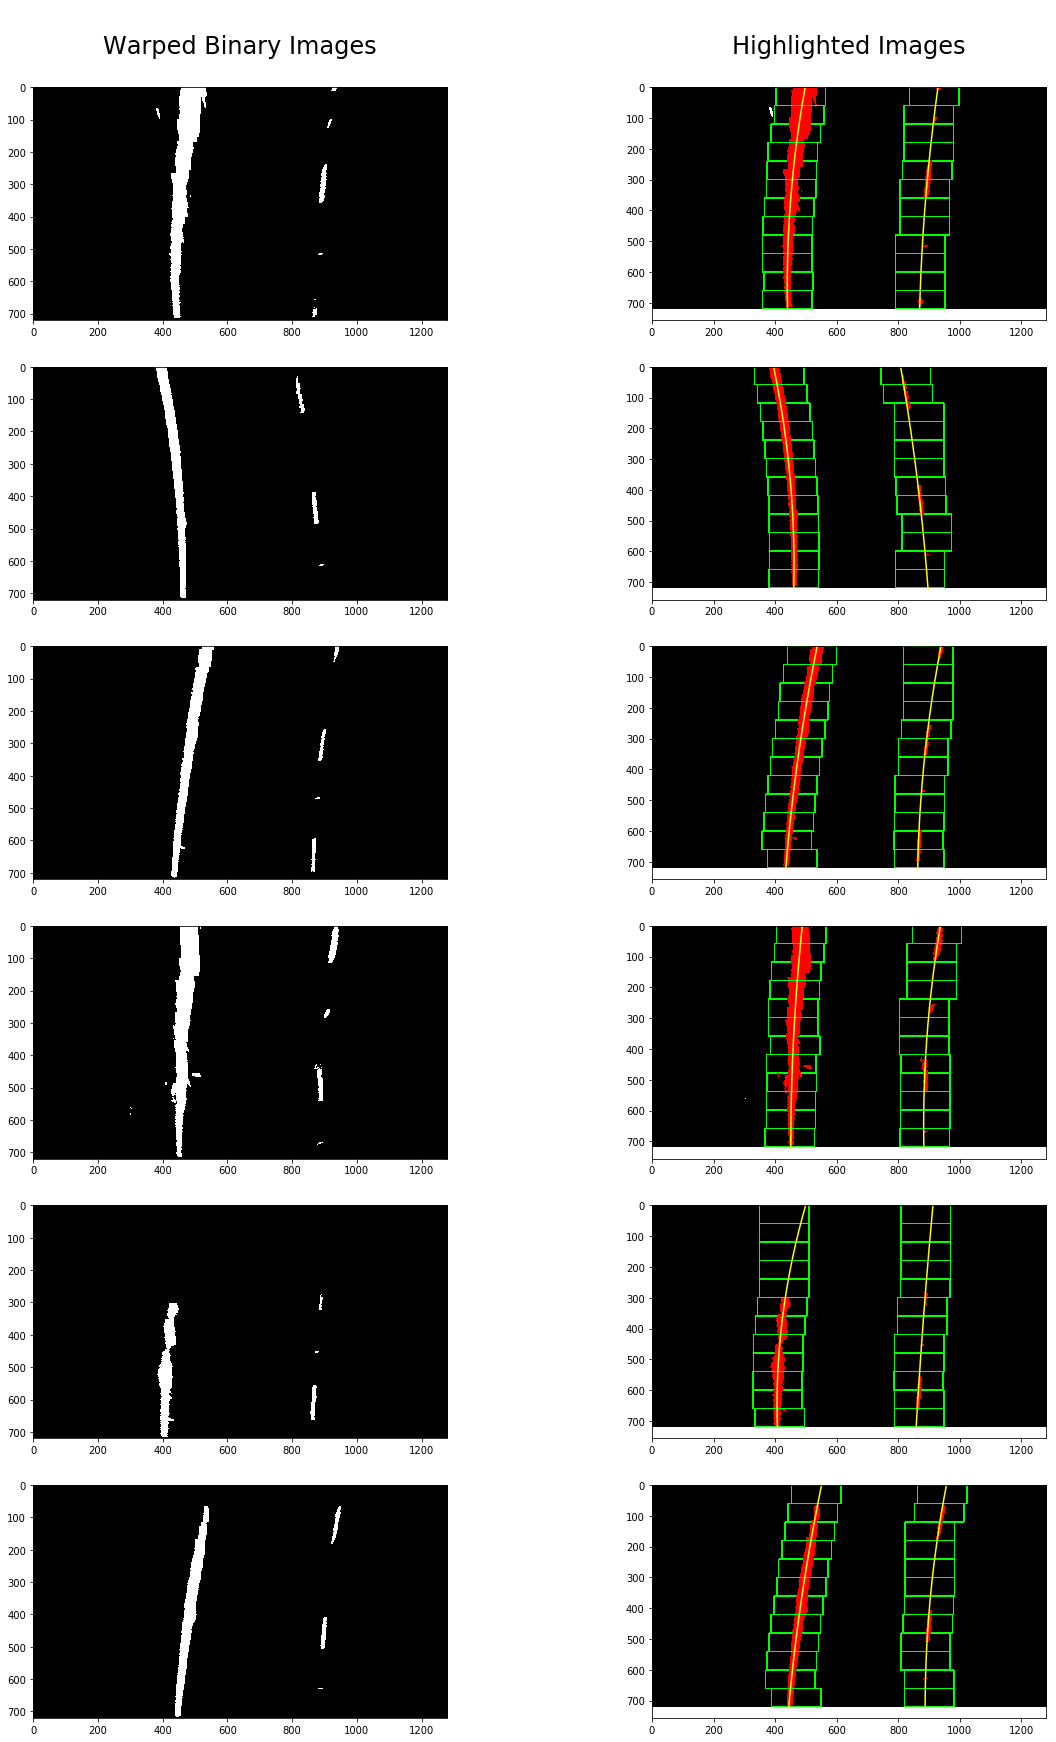

In [24]:
from utils.img import find_lane_lines, get_img_size

# Plot warped and highlighted images
fig = plt.figure(figsize=(20, 30))

for i in range(len(masked_images)):
    masked_image = masked_images[i]
    img_size = get_img_size(masked_image)
    
    ax1 = fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(masked_image, cmap='gray')
    
    result_img, L_L_CF_PX, R_L_CF_PX, L_L_CF_M, R_L_CF_M = find_lane_lines(masked_image, xm_per_px, ym_per_px)

    plot_y = np.linspace(0, img_size[1], img_size[1]+1)
    left_plot_x = L_L_CF_PX[0] * plot_y**2 + L_L_CF_PX[1] * plot_y + L_L_CF_PX[2]
    right_plot_x = R_L_CF_PX[0] * plot_y**2 + R_L_CF_PX[1] * plot_y + R_L_CF_PX[2]
    
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(result_img)
    plt.plot(left_plot_x, plot_y, color='yellow')
    plt.plot(right_plot_x, plot_y, color='yellow')

    # First line should have a title
    if not i:
        ax1.set_title('\nWarped Binary Images\n', fontsize=24)
        ax2.set_title('\nHighlighted Images\n', fontsize=24)
        
fig.savefig('output_images/highlighted.png', bbox_inches='tight')

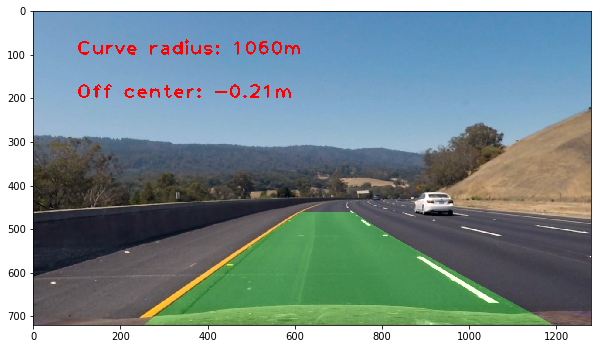

In [25]:
from utils.img import fill_lane, stats

# Show result image
img = fill_lane(images[2,:,:,::-1], Minv, L_L_CF_PX, R_L_CF_PX)
img = stats(img, L_L_CF_M, R_L_CF_M, L_L_CF_PX, R_L_CF_PX, xm_per_px, ym_per_px)

fig = plt.figure(figsize=(10, 20))
plt.imshow(img)

fig.savefig('output_images/result.png', bbox_inches='tight')

In [14]:
# Pipeline
def pipeline(img):
    # Convert RGB -> BGR
    img = img[:,:,::-1]
    
    # Undistort image
    undist_image = undistort(img, mtx, dist)
    
    # Process image
    processed_image = process(undist_image)
    
    # Warp image
    warped_image = warp(processed_image, M)
    
    # Mask the warped image
    masked_image = region_mask(warped_image)
    
    # Find the polynomial coefficients
    warped, L_L_CF_PX, R_L_CF_PX, L_L_CF_M, R_L_CF_M = find_lane_lines(masked_image, xm_per_px, ym_per_px, draw = False)
    #print('{}, {}, {}, {}'.format(L_L_CF_PX, R_L_CF_PX, L_L_CF_M, R_L_CF_M))
    
    # Fill lane
    filled_lane = fill_lane(undist_image[:,:,::-1], Minv, L_L_CF_PX, R_L_CF_PX)
    
    # Add stats
    return stats(filled_lane, L_L_CF_M, R_L_CF_M, L_L_CF_PX, R_L_CF_PX, xm_per_px, ym_per_px)

In [15]:
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile('output_video.mp4', audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [02:55<00:00,  7.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

